In [1]:
import os
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import glob
import cv2
from keras import layers
from sklearn.model_selection import train_test_split
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse
from keras import backend as K
from keras import models
from sklearn.svm import OneClassSVM

In [2]:
%%time
X_list = glob.glob('bottle/train/good/*.png')
Y_list1 = glob.glob('bottle/test/broken_large/*.png')
Y_list2 = glob.glob('bottle/test/broken_small/*.png')
Y_list3 = glob.glob('bottle/test/contamination/*.png')
Y_list4 = glob.glob('bottle/test/good/*.png')
X_train = None
X_test_good = None
X_test_error = None
for X_file in X_list:
  im = cv2.imread(X_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_train is not None:
    X_train = np.concatenate((X_train, im))
  if X_train is None:
    X_train = im

for Y_file in Y_list1:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list2:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list3:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list4:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_good is not None:
    X_test_good = np.concatenate((X_test_good, im))
  if X_test_good is None:
    X_test_good = im
    
# X_train = X_train/255
# X_test_good = X_test_good/255
# X_test_error = X_test_error/255
x_train, x_test = train_test_split(X_train, test_size=0.2)

CPU times: total: 22.4 s
Wall time: 25.8 s


In [3]:
image_size = x_train.shape[1] 
original_dim = image_size * image_size * 3
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train = np.reshape(X_train, [-1, original_dim])
X_train = X_train.astype('float32') / 255

X_test_good = np.reshape(X_test_good, [-1, original_dim])
X_test_good = X_test_good.astype('float32') / 255

X_test_error = np.reshape(X_test_error, [-1, original_dim])
X_test_error = X_test_error.astype('float32') / 255

input_shape = (original_dim, )
latent_dim = 2

In [ ]:
# Reparametrization Trick 
def sampling(args):
    z_mean, z_logvar = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), seed = 5) # ε
    return z_mean + K.exp(0.5 * z_logvar) * epsilon

# VAEモデル構築
inputs = Input(shape=input_shape)
x1 = Dense(256, activation='relu')(inputs)  
x2 = Dense(64, activation='relu')(x1) 
z_mean = Dense(latent_dim)(x2)
z_logvar = Dense(latent_dim)(x2)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_logvar])
encoder = Model(inputs, [z_mean, z_logvar, z], name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,))
x3 = Dense(64, activation='relu')(latent_inputs)  
x4 = Dense(256, activation='relu')(x3)  
outputs = Dense(original_dim, activation='sigmoid')(x4)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

z_output = encoder(inputs)[2]
outputs = decoder(z_output)
vae = Model(inputs, outputs, name='variational_autoencoder')

# 損失関数
# Kullback-Leibler Loss
kl_loss = 1 + z_logvar - K.square(z_mean) - K.exp(z_logvar)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
# Reconstruction Loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(x_train,
                epochs=15,
                batch_size=64,
                validation_data=(x_test, None))

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 196608)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          50331904    ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           16448       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2)            130         ['dense_1[0][0]']                
                                                                                            

In [9]:
# _, _, x_tr = encoder.predict(X_train)
# _, _, x_tg = encoder.predict(X_test_good)
# _, _, x_te = encoder.predict(X_test_error)

x_tr, _, _ = encoder.predict(X_train)
x_tg, _, _ = encoder.predict(X_test_good)
x_te, _, _ = encoder.predict(X_test_error)

ValueError: in user code:

    File "C:\Users\Shuta Tsuchio\anaconda3\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Shuta Tsuchio\anaconda3\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Shuta Tsuchio\anaconda3\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Shuta Tsuchio\anaconda3\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "C:\Users\Shuta Tsuchio\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Shuta Tsuchio\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "encoder" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 196608)


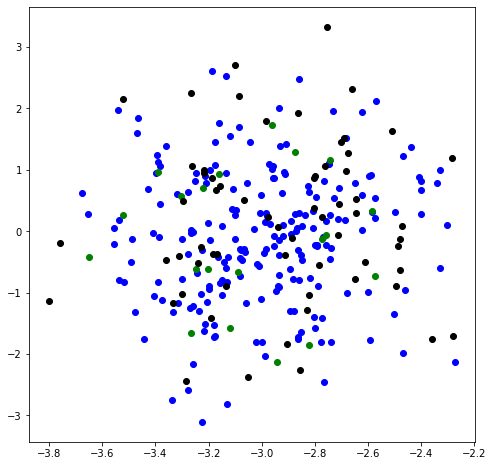

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(x_tr[:, 0], x_tr[:, 1], c='b')
plt.scatter(x_tg[:, 0], x_tg[:, 1], c='g')
plt.scatter(x_te[:, 0], x_te[:, 1], c='black')

train_data = x_tr
test_data_good = x_tg
test_data_error = x_te

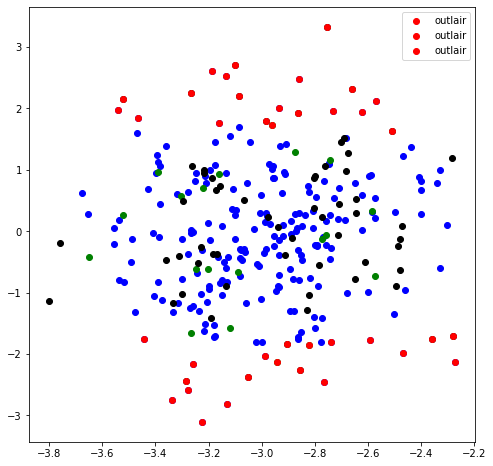

15 48
3 17
accuracy: 0.3855421686746988


In [7]:
clf = OneClassSVM(nu=2**(-3), kernel="rbf", gamma=0.01)
clf.fit(train_data)
pred_tr = clf.predict(train_data)
pred_tg = clf.predict(test_data_good)
pred_te = clf.predict(test_data_error)

index_tr = np.where(pred_tr < 0)
index_tg = np.where(pred_tg < 0)
index_te = np.where(pred_te < 0)
plt.figure(figsize=(8, 8))
plt.scatter(train_data[:,0], train_data[:,1], c='b')
plt.scatter(train_data[index_tr, 0], train_data[index_tr, 1], c='red', label='outlair')

plt.scatter(test_data_good[:,0], test_data_good[:,1], c='g')
plt.scatter(test_data_good[index_tg, 0], test_data_good[index_tg, 1], c='red', label='outlair')

plt.scatter(test_data_error[:,0], test_data_error[:,1], c='black')
plt.scatter(test_data_error[index_te, 0], test_data_error[index_te, 1], c='red', label='outlair')
plt.legend()
plt.savefig('OneClassSVM.png')
plt.show()

in_tg = np.array(index_tg)
in_te = np.array(index_te)

a0, b0 = in_tg.shape
a1, b1 = in_te.shape

TN = len(test_data_good) - b0
FP = b0
FN = len(test_data_error) - b1
TP = b1
print(TP, FN)
print(FP, TN)
print('accuracy:',(TP + TN)/(TP+TN+FP+FN)) 

In [8]:
%%time
s_v = np.array(clf.support_)
SV = []

for i in range(len(s_v)):
    SV.append(list(X_train[s_v[i], :]))
sv = np.array(SV)
sv.shape
# sv = np.reshape(sv, [-1, original_dim])
# sv = sv.astype('float32') / 255

vae.fit(sv, epochs=10, batch_size=64, validation_data=(x_test, None))

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 5.6583 - val_loss: 5.5273
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 5.8371 - val_loss: 5.5367
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 5.5631 - val_loss: 5.5711
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 5.8106 - val_loss: 5.7080
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 5.4528 - val_loss: 5.6798
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 5.8719 - val_loss: 5.3590
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 5.6214 - val_loss: 5.3322
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 5.7611 - val_loss: 6.0441
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 5.5508 - val_loss: 5.2300
Epoch 10/10
1/1 [==============================] - 1s 1s/step - loss: 5.3577 - val_loss: 5.2058
CPU times: total: 1min 2s
Wall time: 43.3 s


2/2 [==============================] - 0s 129ms/step


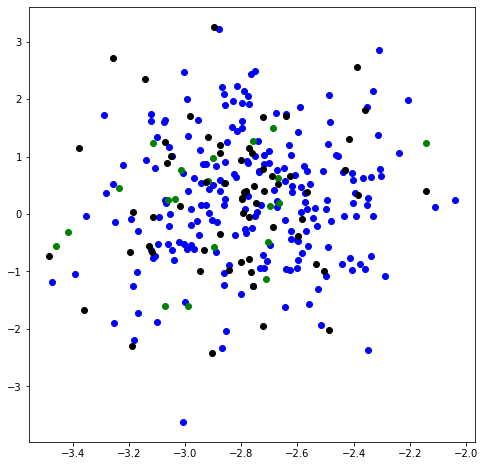

In [16]:
_, _, x_trf = encoder.predict(X_train)
_, _, x_tgf = encoder.predict(X_test_good)
_, _, x_tef = encoder.predict(X_test_error)

# x_trf, _, _ = encoder.predict(X_train)
# x_tgf, _, _ = encoder.predict(X_test_good)
# x_tef, _, _ = encoder.predict(X_test_error)

plt.figure(figsize=(8, 8))
plt.scatter(x_trf[:, 0], x_trf[:, 1], c='b')
plt.scatter(x_tgf[:, 0], x_tgf[:, 1], c='g')
plt.scatter(x_tef[:, 0], x_tef[:, 1], c='black')

train_data = x_trf
test_data_good = x_tgf
test_data_error = x_tef

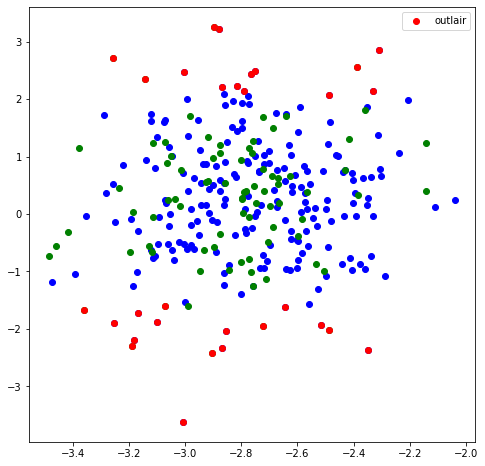

9 54
1 19
accuracy: 0.3855421686746988
CPU times: total: 969 ms
Wall time: 1.56 s


In [17]:
%%time
clf.fit(train_data)
pred_tr = clf.predict(train_data)
pred_tg = clf.predict(test_data_good)
pred_te = clf.predict(test_data_error)

index_tr = np.where(pred_tr < 0)
index_tg = np.where(pred_tg < 0)
index_te = np.where(pred_te < 0)
plt.figure(figsize=(8, 8))
plt.scatter(train_data[:,0], train_data[:,1], c='b')
plt.scatter(train_data[index_tr, 0], train_data[index_tr, 1], c='red', label='outlair')

plt.scatter(test_data_good[:,0], test_data_good[:,1], c='g')
plt.scatter(test_data_good[index_tg, 0], test_data_good[index_tg, 1], c='red')

plt.scatter(test_data_error[:,0], test_data_error[:,1], c='g')
plt.scatter(test_data_error[index_te, 0], test_data_error[index_te, 1], c='red')
plt.legend()
plt.savefig('OneClassSVM.png')
plt.show()

in_tg = np.array(index_tg)
in_te = np.array(index_te)

a0, b0 = in_tg.shape
a1, b1 = in_te.shape

TN1 = len(test_data_good) - b0
FP1 = b0
FN1 = len(test_data_error) - b1
TP1 = b1
print(TP1, FN1)
print(FP1, TN1)
print('accuracy:',(TP + TN)/(TP+TN+FP+FN)) 